# Projet 3 : développer à partir de l’expression de gènes (puce à ADN) un outil de diagnostic, capable de prédire plusieurs types de cancer.

Etudiants :
- Mattei Simon
- Mercado Pablo

## Introduction
### Un rappel sur ce qu'est le cancer
Le cancer est la prolifération de cellules anormales dans un tissu. Elles peuvent utiliser le système sanguin pour voyager et aller affecter d'autres tissus. Certains cancers sont d'origine génétique et ils existent plusieurs facteurs de risques (consommation excessive de tabac et alcool, exposition au soleil, obésité...). Manger une [pomme](https://pubmed.ncbi.nlm.nih.gov/23091184/), faites de l'exercice et manger sainement pour éviter le cancer!

Bien que l'âge ne soit pas la cause directe du cancer, on observe un taux d'incidence plus élevée chez les personnes agées. Avec le vieillissement de la population, la recherche du cancer est un domaine qui pourrait sauver beaucoup de vies.

### Types de cancer
On peut classer les [cancers](https://fr.wikipedia.org/wiki/Cancer) par les organes (et tissus) qu'ils touchent :
*    le cancer du sein
*    le cancer du côlon
*    le cancer du pancréas
*    le cancer de la prostate
*    le cancer du cerveau
*    le myélome multiple : cancer de la moelle osseuse
*    les leucémies
*    le sarcome de Kaposi : cancer des vaisseaux sanguins
*    les lymphomes
*    le cancer des testicules
*    le cancer des poumons
*    le cancer des reins
*    le cancer du foie

### Panel NCI60
Le dataset utilisé prend des [lignées cellulaires (cell line)](https://fr.wikipedia.org/wiki/Lign%C3%A9e_cellulaire_(m%C3%A9decine)), c-à-d des cellules pouvant théoriquement se diviser à l'infini.

In [1]:
import os
import numpy as np
import pylab as plt
%matplotlib inline
import pandas as pd

In [2]:
from Bio import Geo

def load_geo(myfile):
    handle = open(myfile)
    records = Geo.parse(handle)
    return records

records = load_geo('GDS4296.soft')

On extrait quelques informations sur le panel...

In [3]:
f = open("soft-info.txt", "w")

while True:
    try:
        nr = next(records)
        f.write(str(nr))
        f.write('\n---------------------- ENTITY_ATTRIBUTES:------------------------------\n')
        f.write(str(nr.entity_attributes))
    except StopIteration:
        print("done reading")
        break

done reading


Extrayons les données utiles: niveaux d'expressions des conditions et sources des conditions.

In [4]:
records = load_geo('GDS4296.soft')

# description of each condition (cell type)
id_cond_tissue = {}
diseases = set()

# loop over records
for r in records:
    rea = r.entity_attributes

    # condition for cell type/tissue/disease state
    if 'subset_dataset_id' in rea:
        sample_list = rea['subset_sample_id'].split(',')
        desc = rea['subset_description']

        if rea['subset_type'] == 'tissue':
            for sample in sample_list:
                id_cond_tissue[sample] = desc
                diseases.add(desc)

        # si l'on veut plus de détail sur la variété de cancer
        # e.g. https://fr.wikipedia.org/wiki/Astrocytome
        #if rea['subset_type'] == 'disease state':
            #for sample in sample_list:
                #id_cond_disease[sample] = desc
                #disease_with_details.add(desc)

    if 'dataset_table_begin' in rea:
        data = r.table_rows

# converts data to an array (more practical to handle)
data = np.array(data)
print(len(id_cond_tissue))

174


On désire connaître la proportion de cancer répertorié dans les échantillons. Histoire de vérifier qu'il y a suffisamment d'échantillons pour faire notre classificateur.

In [5]:
cancer_sample_count = {}
for cancer in diseases:
    cancer_sample_count[cancer] = 0
    for sample in id_cond_tissue:
        if cancer == id_cond_tissue[sample]:
            cancer_sample_count[cancer] = cancer_sample_count[cancer] + 1

total_sample = len(id_cond_tissue)

print("{: >20} {: >20}".format("Cancer location", '# échantillons'), '\tquantité (%)')
print('------------------------------------------------------------------')
for cancer in cancer_sample_count:
    print("{: >20} {: >20}".format(cancer, cancer_sample_count[cancer]), '\t', "{0:.2f}".format(cancer_sample_count[cancer]/total_sample*100))

     Cancer location       # échantillons 	quantité (%)
------------------------------------------------------------------
               colon                   21 	 12.07
            melanoma                   26 	 14.94
 non-small cell lung                   26 	 14.94
            prostate                    6 	 3.45
               renal                   23 	 13.22
            leukemia                   18 	 10.34
                 CNS                   18 	 10.34
              breast                   15 	 8.62
             ovarian                   21 	 12.07


Seul les échantillons de la prostate sont en petites quantités (3% de l'échantillonage).

Afin de mener nos recherches en étant objectif, on divise notre jeu de données en données de train et données de test:

In [6]:
import random

# init dictionnary with disease - empty list
diseases_cond = {}
for disease in diseases:
    diseases_cond[disease] = []

# add every condition to dictionnary
for cond in id_cond_tissue:
    diseases_cond[id_cond_tissue[cond]].append(cond)

# shuffle conditions and add them to train/test conditions
test_conds = []
train_conds = []
for disease in diseases_cond:
    random.shuffle(diseases_cond[disease])
    idx_sep = int(len(diseases_cond[disease]) / 5) # 80/20%
    test_conds += diseases_cond[disease][:idx_sep]
    train_conds += diseases_cond[disease][idx_sep:]

# seperate data according to conditions
idx_test = []
for cond in test_conds:
    idx_test.append(data[0,:].tolist().index(cond))

idx_train = list(range(0,len(id_cond_tissue)+2))
[idx_train.remove(i) for i in idx_test]

data_test = data[:,idx_test]
data_train = data[:,idx_train]

print(np.shape(data_train))
print(np.shape(data_test))

(54676, 144)
(54676, 32)


On veut sélectionner les gènes pertinents dans notre jeu de train pour former notre classificateur. Affichons déjà les niveaux d'expression pour un gène aux travers des échantillons:

In [7]:
# cell types
cell_type = list(diseases) 
print('cell_type:\t'+str(cell_type))

# idx_cell_type will be used to re-order the columns of data as a function of cell_type
idx_cell_type = [0,1] # we don't want to re-order the first two columns (= gene name and identifier)

# colors will be used when plotting the data (each cell type has a corresponding color)
unique_colors = ['red','green','blue','cyan','magenta','yellow','purple','orange','lime']
colors_cell_type = [] 

# for every type in cell_type, find the corresponding colums in data and add them to idx_cell_type
for j,ct in enumerate(cell_type):
    elements_cell_type = [ i+2 for i,c in enumerate(data_train[0,2:]) if id_cond_tissue[c]==ct]
    idx_cell_type.extend(elements_cell_type)
    for _ in range(len(elements_cell_type)):
        colors_cell_type.append(unique_colors[j])
print('\nidx_cell_type:\t'+str(idx_cell_type))    
print('\ncolors_cell_type:\t'+str(colors_cell_type))

# re-order columns of data (= conditions) with idx_cell_type
data_train = data_train[:,idx_cell_type]

cell_type:	['colon', 'melanoma', 'non-small cell lung', 'prostate', 'renal', 'leukemia', 'CNS', 'breast', 'ovarian']

idx_cell_type:	[0, 1, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 27, 28, 29, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 118, 119, 120, 121, 122, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 17, 18, 19, 20, 21, 22, 24, 25, 26, 141, 142, 143, 23, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117]

colors_cell_type:	['red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 

1372

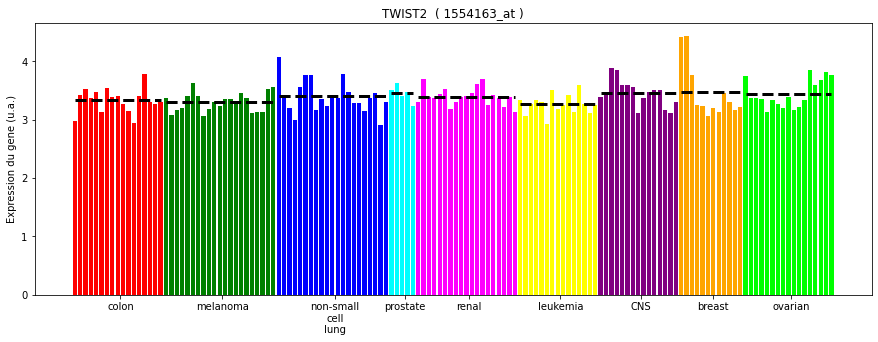

In [12]:
def mean_expressions(data,colors_cell_type):
    
    data_separated = np.zeros(len(unique_colors))
    for j,color in enumerate(unique_colors):
        data_separated[j] = np.nanmean([float(data[i]) for i,c in enumerate(colors_cell_type) if c==color])
        
    return data_separated

def plot_gene_expression_across_conditions(data,gene,cell_type,colors_cell_type):
    
    # find the line in data corresponding to our gene of interest and get the gene expression levels
    idx_gene = [i for i,x in enumerate(data[:,0]) if x==gene][0]
    data_to_show = (data_train[idx_gene,2:]).tolist() # remove the first two elements corresponding to gene name and identifier
    data_to_show = np.array(data_to_show,dtype=float) # convert to float
    
    # plot the data
    fig, ax = plt.subplots(figsize=(15, 5))
    plt.bar(range(0,len(data_to_show)),data_to_show,color=colors_cell_type)
    plt.title(data_train[idx_gene,1]+'  ( '+data_train[idx_gene,0]+' )')

    # represent the mean gene expression in normal and cancer cells with a dashed line
    means = mean_expressions(data_to_show,colors_cell_type)
    first, last = (0,0)
    xticks = []
    for i,mean in enumerate(means):
        color = unique_colors[i]
        while last < len(colors_cell_type) and colors_cell_type[last] == color:
            last += 1
        xticks.append(first + ((last-first)/2))
        plt.hlines(mean,first,last - 1,linestyles='--',color='black',lw=3) # draw a line to show mean(expression of cancer cells)
        first = last
        
    ax.set_xticks(xticks)
    ax.set_xticklabels([ct.replace(' ','\n').replace('plus','+') for ct in cell_type])
    ax.set_ylabel('Expression du gene (u.a.)')
    
    return idx_gene

gene = '1554163_at'
plot_gene_expression_across_conditions(data_train,gene,cell_type,colors_cell_type)
# '1554165_at'